In [1]:
import matplotlib.pyplot as plt
import numpy as np

import pyxdf

In [6]:
WPI_xdf_path = "../HCILab1-Group5.xdf"
CSL_xdf_path = "../CSL_Laptop_0111.xdf"

### View XDF Streams

In [3]:
def view_xdf_streams(xdf_path):
    data, header = pyxdf.load_xdf(xdf_path)
    print(header)

    for stream in data:
        stream_name = stream["info"]["name"][0]
        stream_id = stream["info"]["stream_id"]
        stream_srate = stream["info"]["effective_srate"]
        
        print(f'Stream {stream_name} (Stream ID: {stream_id} with sampling rate {stream_srate})')

In [4]:
view_xdf_streams(WPI_xdf_path)

Stream 4: Calculated effective sampling rate 17.3545 Hz is different from specified rate 30.0000 Hz.


{'info': defaultdict(<class 'list'>, {'version': ['1.0'], 'datetime': ['2024-11-01T09:47:31-0400']})}
Stream Unicorn_HCILab1 (Stream ID: 1 with sampling rate 250.31200597269847)
Stream OBS_HCILab1 (Stream ID: 3 with sampling rate 29.999622227800188)
Stream OBS_HCILab2 (Stream ID: 4 with sampling rate 17.354547902601965)
Stream Unicorn_HCILab2 (Stream ID: 2 with sampling rate 236.18465134826533)
Stream OBS_CSL_Laptop (Stream ID: 5 with sampling rate 29.99984725971537)


In [7]:
view_xdf_streams(CSL_xdf_path)

{'info': defaultdict(<class 'list'>, {'version': ['1.0'], 'datetime': ['2024-11-01T14:47:31+0100']})}
Stream OBS_CSL_Laptop (Stream ID: 2 with sampling rate 30.000000298608494)
Stream Unicorn_CSL_Laptop (Stream ID: 3 with sampling rate 250.2580436080314)
Stream OBS_CSL_LabPC (Stream ID: 4 with sampling rate 60.000005229231036)
Stream Unicorn_HCILab1 (Stream ID: 1 with sampling rate 250.31339114537593)


WPI HCI Lab Streams:


Stream 4: Calculated effective sampling rate 17.3545 Hz is different from specified rate 30.0000 Hz.


Stream Unicorn_HCILab1 has 983723 time stamps, starting with 3638.185369910576


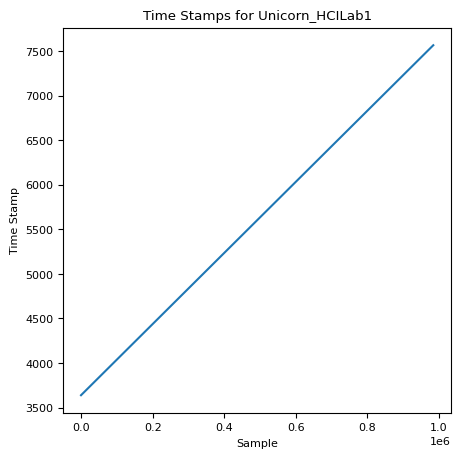

Stream OBS_HCILab1 has 117898 time stamps, starting with 3638.2590426561956
Stream OBS_HCILab1 with time series (UNIX) begins with 1730468851.254
Stream OBS_HCILab2 has 69373 time stamps, starting with 3613.3562312388003
Stream OBS_HCILab2 with time series (UNIX) begins with 1730468858.351
Stream Unicorn_HCILab2 has 926038 time stamps, starting with 3634.3625993748656


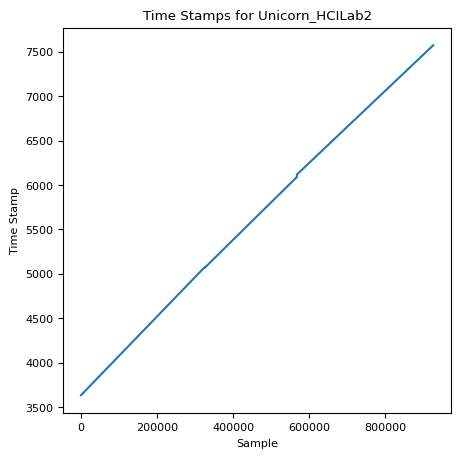

Stream OBS_CSL_Laptop has 117891 time stamps, starting with 3638.456594091462
Stream OBS_CSL_Laptop with time series (UNIX) begins with 1730468851.765

CSL Lab Streams:
Stream OBS_CSL_Laptop has 117118 time stamps, starting with 7535833.465214105
Stream OBS_CSL_Laptop with time series (UNIX) begins with 1730468851.732
Stream Unicorn_CSL_Laptop has 977014 time stamps, starting with 7535833.224962798


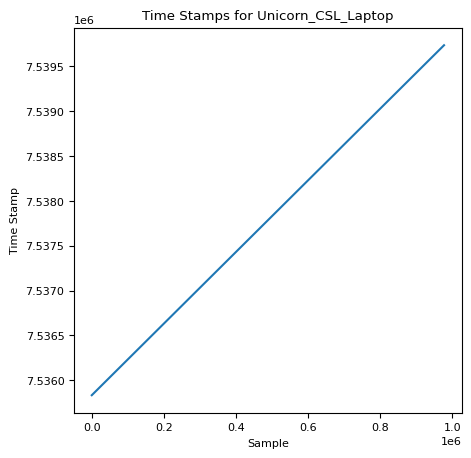

Stream OBS_CSL_LabPC has 41715 time stamps, starting with 7535833.4446814805
Stream OBS_CSL_LabPC with time series (UNIX) begins with 1730468851.72
Stream Unicorn_HCILab1 has 977164 time stamps, starting with 7535833.52756145


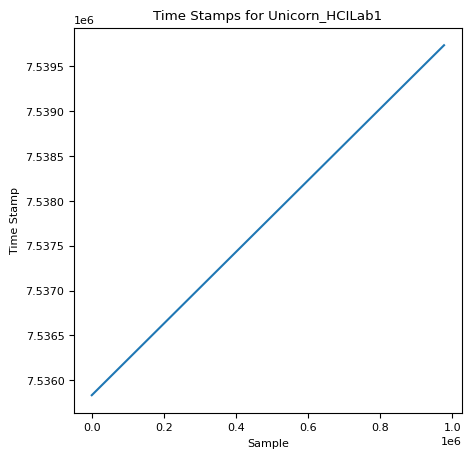

In [8]:
def examine_timestamps_length(xdf_path):
    data, header = pyxdf.load_xdf(xdf_path)
    
    for stream in data:
        stream_name = stream["info"]["name"][0]
        
        time_stamps = stream["time_stamps"]
        
        print(f'Stream {stream_name} has {len(time_stamps)} time stamps, starting with {time_stamps[0]}')
        
        time_series = stream["time_series"]
        if stream_name.startswith("OBS"):
            print(f"Stream {stream_name} with time series (UNIX) begins with {time_series[0][0]}")
        
        if "Unicorn" in stream_name:
            # plot the time stamps
            plt.rc('font', size=8)
            plt.figure(figsize=(5, 5))
            plt.plot(time_stamps)
            plt.xlabel('Sample')
            plt.ylabel('Time Stamp')
            plt.title(f"Time Stamps for {stream_name}")
            plt.show()

# Examine the length of all time stamps in each stream for both XDF files
print("WPI HCI Lab Streams:")
examine_timestamps_length(WPI_xdf_path)

print("\nCSL Lab Streams:")
examine_timestamps_length(CSL_xdf_path)

### Sync Streams!!

In [9]:
def sync_streams(data_streams_1, data_streams_2):
    
    """
    Sync the data by trimming time_stamp and time_series streams so that all EEG and Unicorn Streams begin at the same time
    
    Parameters:
    - data_streams_1: Stream data from WPI HCI Lab xdf file
    - data_streams_2: Stream data from CSL Lab xdf file
    """
    
    # Holds the 8 streams (4 OBS and 4 Unicorn)
    streams = {}
    
    # Create mappings of the 8 stream names to streams
    for stream in data_streams_1:
        stream_name = stream["info"]["name"][0]
        
        if stream_name in ["OBS_HCILab1", "Unicorn_HCILab1", "OBS_HCILab2", "Unicorn_HCILab2"]:
            streams[stream_name] = stream
            
    for stream in data_streams_2:
        stream_name = stream["info"]["name"][0]
        
        if stream_name in ["OBS_CSL_Laptop", "Unicorn_CSL_Laptop", "OBS_CSL_LabPC", "Unicorn_CSL_LabPC"]:
            streams[stream_name] = stream
    
    # From the OBS Video (when Chris says "Begin" and "Time's Up")
    start_unix_timestamp = 1730469121.993
    end_unix_timestamp = 1730472641.084
    duration = end_unix_timestamp - start_unix_timestamp
    frames = 250 * duration
    
    # Trim all the other streams based on the latest Unix timestamp
    for OBS_stream_name, EEG_stream_name in [("OBS_HCILab1", "Unicorn_HCILab1"), ("OBS_HCILab2", "Unicorn_HCILab2"), ("OBS_CSL_Laptop", "Unicorn_CSL_Laptop")]:
        OBS_stream = streams[OBS_stream_name]
        EEG_stream = streams[EEG_stream_name]
        
        # First, find the LabRecorder timestamp in the OBS stream that corresponds to the start and end Unix timestamp
        OBS_unix_times = [ts[0] for ts in OBS_stream["time_series"]]
        start_OBS_index = np.searchsorted(OBS_unix_times, start_unix_timestamp)
        end_OBS_index = np.searchsorted(OBS_unix_times, end_unix_timestamp)
        
        start_labrecorder_timestamp = OBS_stream["time_stamps"][start_OBS_index]
        
        # Find the index in the EEG stream where this LabRecorder timestamp occurs
        start_EEG_index = np.searchsorted(EEG_stream["time_stamps"], start_labrecorder_timestamp)
        end_EEG_index = start_EEG_index + round(frames)
        
        # Trim all the data in the OBS and EEG streams based on this index
        OBS_stream["time_stamps"] = OBS_stream["time_stamps"][start_OBS_index:end_OBS_index]
        OBS_stream["time_series"] = OBS_stream["time_series"][start_OBS_index:end_OBS_index]
        EEG_stream["time_stamps"] = EEG_stream["time_stamps"][start_EEG_index:end_EEG_index]
        EEG_stream["time_series"] = EEG_stream["time_series"][start_EEG_index:end_EEG_index]
    
    return streams

In [10]:
# Load the XDF data for both labs
WPI_data_streams, WPI_header = pyxdf.load_xdf(WPI_xdf_path)
CSL_data_streams, CSL_header = pyxdf.load_xdf(CSL_xdf_path)

Stream 4: Calculated effective sampling rate 17.3545 Hz is different from specified rate 30.0000 Hz.


In [11]:
# Before syncing the streams, let's examine the time_stamps and time_series in both files
def print_time_stamps_and_series(data_streams):
    for stream in data_streams:
        stream_name = stream["info"]["name"][0]
        print(f'\nStream {stream_name} has {len(stream["time_stamps"])} time stamps and {len(stream["time_series"])} time series')
        
        if len(stream["time_stamps"]) > 0:
            print(f'Time stamps: [{stream["time_stamps"][0]} ... {stream["time_stamps"][-1]}]')
        
        if stream_name.startswith("OBS") and len(stream["time_series"]) > 0:
            print(f'Time series (UNIX): [{stream["time_series"][0][0]} ... {stream["time_series"][-1][0]}]')
        
print("WPI HCI Lab Streams before syncing:")
print_time_stamps_and_series(WPI_data_streams)

print("\nCSL Lab Streams before syncing:")
print_time_stamps_and_series(CSL_data_streams)

WPI HCI Lab Streams before syncing:

Stream Unicorn_HCILab1 has 983723 time stamps and 983723 time series
Time stamps: [3638.185369910576 ... 7568.168651892147]

Stream OBS_HCILab1 has 117898 time stamps and 117898 time series
Time stamps: [3638.2590426561956 ... 7568.208530598049]
Time series (UNIX): [1730468851.254 ... 1730472781.4]

Stream OBS_HCILab2 has 69373 time stamps and 69373 time series
Time stamps: [3613.3562312388003 ... 7610.718876719695]
Time series (UNIX): [1730468858.351 ... 1730472788.295]

Stream Unicorn_HCILab2 has 926038 time stamps and 926038 time series
Time stamps: [3634.3625993748656 ... 7572.341849046049]

Stream OBS_CSL_Laptop has 117891 time stamps and 117891 time series
Time stamps: [3638.456594091462 ... 7568.143268309877]
Time series (UNIX): [1730468851.765 ... 1730472781.383]

CSL Lab Streams before syncing:

Stream OBS_CSL_Laptop has 117118 time stamps and 117118 time series
Time stamps: [7535833.465214105 ... 7539737.365175247]
Time series (UNIX): [173

In [12]:
# Sync the streams based on the shared stream's timestamp
streams = sync_streams(WPI_data_streams, CSL_data_streams)

In [13]:
print("WPI HCI Lab Streams AFTER syncing:")
print_time_stamps_and_series(WPI_data_streams)

print("\nCSL Lab Streams AFTER syncing:")
print_time_stamps_and_series(CSL_data_streams)

WPI HCI Lab Streams AFTER syncing:

Stream Unicorn_HCILab1 has 879773 time stamps and 879773 time series
Time stamps: [3909.031347316004 ... 7423.732911330524]

Stream OBS_HCILab1 has 105565 time stamps and 105565 time series
Time stamps: [3909.029118998695 ... 7427.873430093072]
Time series (UNIX): [1730469122.02 ... 1730472641.062]

Stream OBS_HCILab2 has 61608 time stamps and 61608 time series
Time stamps: [3895.1284640762788 ... 7445.055242893978]
Time series (UNIX): [1730469122.025 ... 1730472641.043]

Stream Unicorn_HCILab2 has 867209 time stamps and 867209 time series
Time stamps: [3895.128474589086 ... 7572.341849046049]

Stream OBS_CSL_Laptop has 117891 time stamps and 117891 time series
Time stamps: [3638.456594091462 ... 7568.143268309877]
Time series (UNIX): [1730468851.765 ... 1730472781.383]

CSL Lab Streams AFTER syncing:

Stream OBS_CSL_Laptop has 105574 time stamps and 105574 time series
Time stamps: [7536103.731878082 ... 7539622.831843054]
Time series (UNIX): [173046

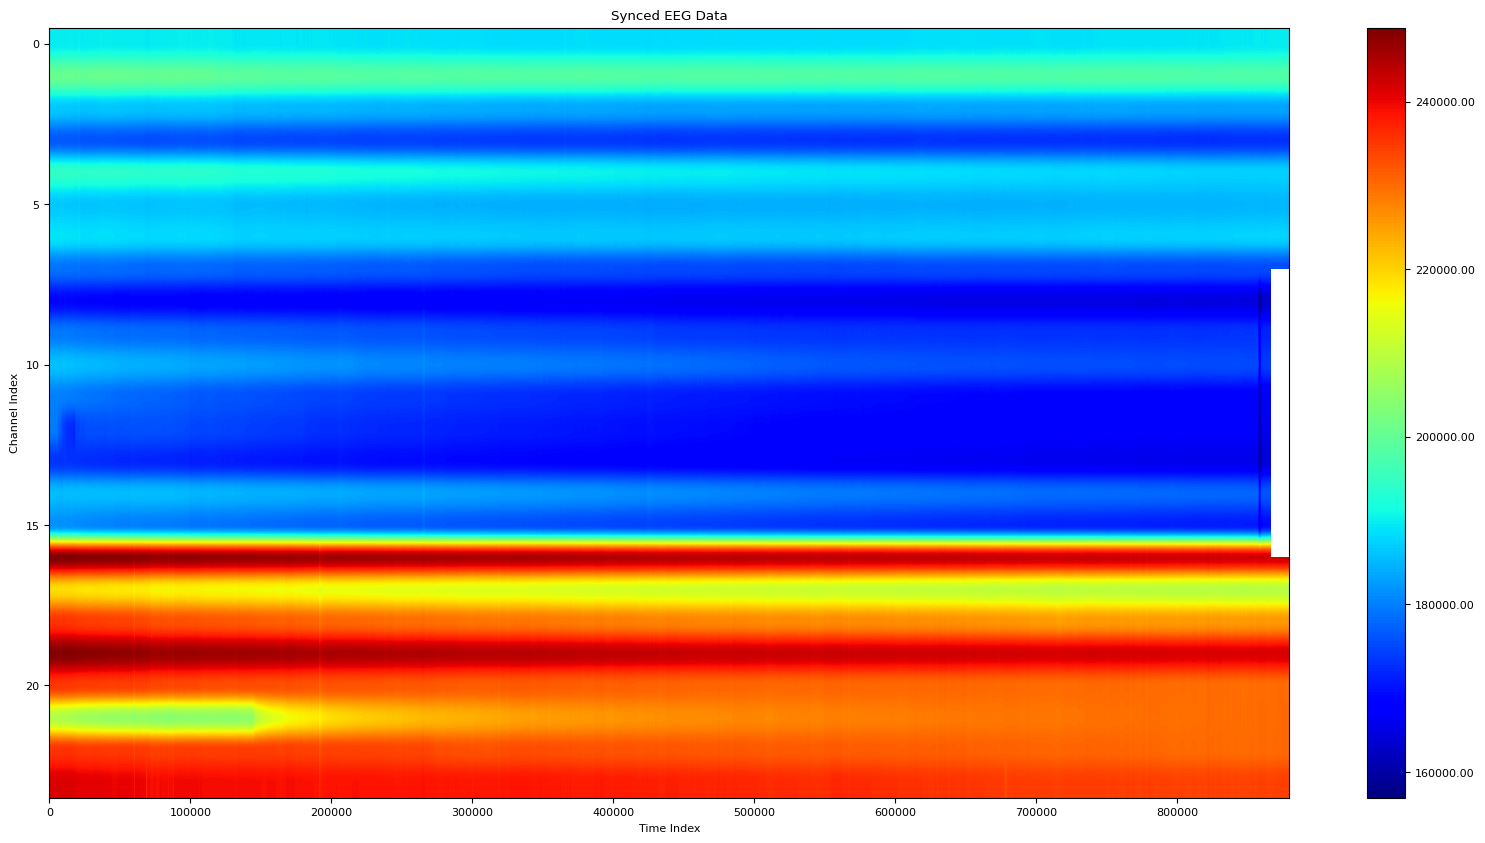

Min: 156920.6875
Max: 248834.453125
Mean: 196924.90026769528
Standard Deviation: 26462.2130033429


In [15]:
import scipy.io

# Disable scientific notation in NumPy globally
np.set_printoptions(suppress=True)

# find the max length of time_series in all EEG streams to establish dimensions for synced EEG streams
max_length = 0

for stream_name in ["Unicorn_HCILab1", "Unicorn_HCILab2", "Unicorn_CSL_Laptop"]:
    max_length = max(max_length, len(streams[stream_name]["time_series"]))

# Create an np array to hold the synced EEG data with dimensions (max_length, 3 * 8)
# 3 streams (there was no Unicorn_CSL_LabPC), 8 channels each
synced_EEG_data = np.full((max_length, 3 * 8), np.nan)

# Fill in the synced EEG data
for j, stream_name in enumerate(["Unicorn_HCILab1", "Unicorn_HCILab2", "Unicorn_CSL_Laptop"]):
    EEG_stream = streams[stream_name]
    
    for time_index, eeg_data in enumerate(EEG_stream["time_series"]):
        synced_EEG_data[time_index, j * 8:(j + 1) * 8] = eeg_data[0:8]

# Visualize the synced EEG data
plt.figure(figsize=(20, 10))
plt.imshow(synced_EEG_data.T, aspect='auto', cmap='jet')
plt.colorbar(format='%.2f')  # Ensures color bar does not use scientific notation
plt.title("Synced EEG Data")
plt.xlabel("Time Index")
plt.ylabel("Channel Index")
plt.show()

print("Min:", np.nanmin(synced_EEG_data))
print("Max:", np.nanmax(synced_EEG_data))
print("Mean:", np.nanmean(synced_EEG_data))
print("Standard Deviation:", np.nanstd(synced_EEG_data))

# Download the EEG data as an .mat file
scipy.io.savemat('task_cutoff_EEG_data_5.mat', {'task_cutoff_EEG_data_5': synced_EEG_data})